In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import seaborn as sns

In [35]:
# setup directories

datadir = '/home/xavier/data/claims/'

# year12 = 'Medicare_Provider_Util_Payment_PUF_CY2012.txt'
# year13 = 'Medicare_Provider_Util_Payment_PUF_CY2013.txt'
# year14 = 'Medicare_Provider_Util_Payment_PUF_CY2014.txt'
year15 = 'Medicare_Provider_Util_Payment_PUF_CY2015.txt'

cancer_doctor_types = 'cancer_doctor_types.csv'

fields_lowercase = ['npi','nppes_provider_street1','nppes_provider_street2','provider_type','hcpcs_code','hcpcs_description','line_srvc_cnt','bene_day_srvc_cnt']



# Medicare Provider Utilization and Payment Data: Physician and Other Supplier PUF CY2015


> The Centers for Medicare & Medicaid Services (CMS) has prepared a public data set, the Provider Utilization and Payment Data Physician and Other Supplier Public Use File (herein referred to as “Physician and Other Supplier PUF”), with information on services and procedures provided to Medicare beneficiaries by physicians and other healthcare professionals. T

+ this Public Dataset [can be downloaded](https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/sk9b-znav)
+ What's in this DataSet?

| Rows | Columns | Each row is a | 
| - - - | - - - | - - - | 
| 9.5M | 26 | Physician/HCPCS | 





In [36]:
# load all physican data
df15 = pd.read_csv(datadir + year15, usecols=fields_lowercase, sep='\t', lineterminator='\n')

In [37]:
# load the physican types which are marked as "likely to treat cancer"
# (NOTE: this was an arbitrary selection, but seems decent to start with)
all_treaters = pd.read_csv(datadir + cancer_doctor_types)
marked_cancer = all_treaters[all_treaters["CANCER_TESTS"]=="yes"]
cancer_treater_list = marked_cancer.PROVIDER_TYPE
cancer_treater_list

1                           Internal Medicine
15                        Hematology/Oncology
18                                  Pathology
21                        Clinical Laboratory
29                         Radiation Oncology
35                           Medical Oncology
44    Independent Diagnostic Testing Facility
62                     Gynecological/Oncology
64                                 Hematology
Name: PROVIDER_TYPE, dtype: object

In [38]:
# list the loaded column names 
list(df15)

['npi',
 'nppes_provider_street1',
 'nppes_provider_street2',
 'provider_type',
 'hcpcs_code',
 'hcpcs_description',
 'line_srvc_cnt',
 'bene_day_srvc_cnt']

In [39]:
df15.head()

,npi,nppes_provider_street1,nppes_provider_street2,provider_type,hcpcs_code,hcpcs_description,line_srvc_cnt,bene_day_srvc_cnt
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003000126,900 SETON DR,NaN,Internal Medicine,99217,Hospital observation care discharge,23.0,23.0
2,1003000126,900 SETON DR,NaN,Internal Medicine,99219,Hospital observation care typically 50 minutes,18.0,18.0
3,1003000126,900 SETON DR,NaN,Internal Medicine,99221,"Initial hospital inpatient care, typically 30 ...",59.0,59.0
4,1003000126,900 SETON DR,NaN,Internal Medicine,99222,"Initial hospital inpatient care, typically 50 ...",132.0,132.0


# Starting with the Topline: 
## 1) Types of HCPs in dataset
## 2) Oncologist & Pathologist claims vs total claims

In [40]:
# find all doctor types
all_doctors = df15.groupby("provider_type").size().reset_index(name='count')
all_doctors.sort_values(by='count', ascending=False,inplace=True)
all_doctors.shape

(91, 2)

In [41]:
# Export doctors types
# all_doctors.to_csv(datadir + 'all_doctor_types.csv')

In [42]:
# group Top 20 doctor types
top_doctor_types = all_doctors.head(21)

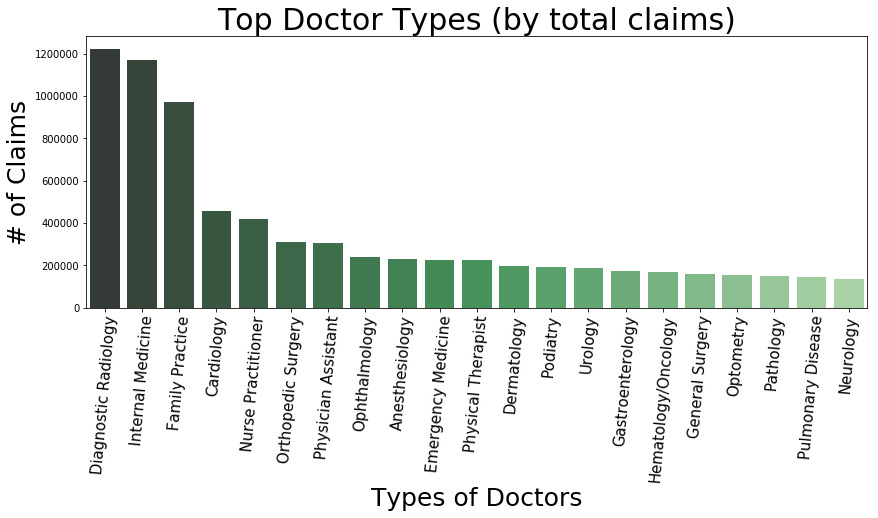

In [43]:
# Plot the Top 20 Doctor types (making the most claims) 
width=14
height=5
figure(figsize=(width,height))

ax = sns.barplot(x=top_doctor_types["provider_type"], y=top_doctor_types["count"],palette="Greens_d")

plt.xticks(rotation= 85,fontsize=15)
plt.xlabel('Types of Doctors',fontsize=25)
plt.ylabel('# of Claims',fontsize=25)
plt.title('Top Doctor Types (by total claims)',fontsize=30)

# Show the plot
plt.show()

### FINDING ➜ Pathologists & Oncologists make it into the Top 20 (of total claims, by Doctor Type)

In [44]:
# sum up to the total number
# of claims for ALL doctors vs. CANCER TREATERS

total_claims = df15.line_srvc_cnt.sum()
cancer_treaters = df15.loc[df15['provider_type'].isin(cancer_treater_list)]
cancer_claims = cancer_treaters.line_srvc_cnt.sum()

In [45]:
# prepare to plot this
raw_data = {'CLAIMS': ['Claims from All Doctors', 'Claims from Cancer Treaters'], 
        'AMOUNT': [total_claims, cancer_claims]}
claims_comparison = pd.DataFrame(raw_data, columns = ['CLAIMS', 'AMOUNT'])
claims_comparison

,CLAIMS,AMOUNT
0,Claims from All Doctors,2.359294e+09
1,Claims from Cancer Treaters,9.218618e+08


Text(0.5,1,'Total Claims vs. Cancer Treater Claims')

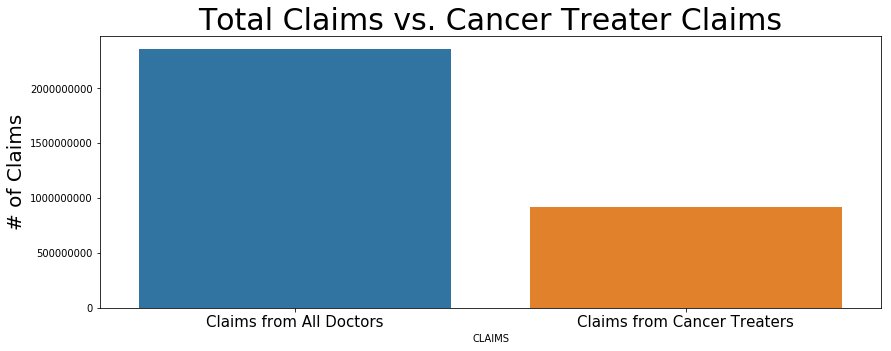

In [46]:
# Plot the Total Claims vs. the Cancer Claims 
width=14
height=5
figure(figsize=(width,height))

p = sns.barplot(x=claims_comparison["CLAIMS"], y  = claims_comparison["AMOUNT"])

plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=15)
plt.ylabel('# of Claims',fontsize=20)
plt.title('Total Claims vs. Cancer Treater Claims',fontsize=30)




### FINDING ➜ When comparing the claims from Doctors most likley to test for cancer to the total, a surprising number of the claims cames from Cancer Treaters. 

+ This is likely because "Cancer Treaters" includes the broad category of **"Internal Medicine"**, adding a lot of bulk to that number 

- - -
# Next, looking at "Cancer Treater" services: 
## 1) Top Oncologist / Pathologist Services...
## 2) ...compared to top genetic tests by same doctors

In [51]:
genetic15 = df15[df15['hcpcs_description'].str.contains("genetic", na=False)]

In [47]:
# genetic15.shape

In [52]:
df = genetic15[genetic15["hcpcs_description"].str.contains("Analysis of cell function and analysis for genetic marker", na=False)]
df

,npi,nppes_provider_street1,nppes_provider_street2,provider_type,hcpcs_code,hcpcs_description,line_srvc_cnt,bene_day_srvc_cnt
617939,1063497451,69 1ST AVE,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,63.0,63.0
1957858,1205872041,900 BUSINESS CENTER DR,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,495.0,495.0
2126378,1225074065,575 UNDERHILL BLVD,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,25.0,25.0
2367584,1245494517,1261 LIBERTY WAY,SUITE C,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,48.0,48.0
3469565,1366479099,8401 FALLBROOK AVE,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,34.0,34.0
3566391,1376587113,250 MILLER PL,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,18.0,18.0
4106689,1437135886,1440 YORK CT,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,94.0,94.0
5066748,1538144910,1447 YORK CT,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,15.0,15.0
5204077,1548370745,1701 CENTURY CENTER CV,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,28.0,28.0
5848632,1619913449,3714 NORTHGATE BLVD,NaN,Clinical Laboratory,86352,Analysis of cell function and analysis for gen...,57.0,57.0


In [53]:
pd.pivot_table(genetic15,index=["hcpcs_description","provider_type"],values = ["line_srvc_cnt","bene_day_srvc_cnt"],aggfunc=np.sum)

bene_day_srvc_cnt  \
hcpcs_description                                  provider_type                                         
Analysis of cell function and analysis for gene... Clinical Laboratory                          1422.0   
Analysis of female reproductive genetic marker     Clinical Laboratory                          2202.0   
Analysis of genetic material                       Clinical Laboratory                          8177.0   
                                                   Dermatology                                    26.0   
                                                   Hematology                                     46.0   
                                                   Hematology/Oncology                            40.0   
                                                   Oral Surgery (dentists only)                   32.0   
                                                   Pathology                                   13267.0   
                                                   Unknown Physician Specialty Code               96.0   
Chemical test for genetic disorder                 Clinical Laboratory                            29.0   
                                                   Pathology                                      20.0   
Chromosome analysis for genetic defects            Clinical Laboratory                         53549.0   
                                                   Pathology                                    3488.0   
                                                   Pediatric Medicine                             28.0   
Chromosome analysis of amniotic fluid or placen... Clinical Laboratory                            34.0   
DNA testing for genetic defects                    Clinical Laboratory                         21106.0   
                                                   Pathology                                     900.0   
Identification of organisms by genetic analysis    Clinical Laboratory                         13468.0   
                                                   Infectious Disease                             25.0   
                                                   Pathology                                     103.0   
Interpretation and report of genetic testing       Clinical Laboratory                         28233.0   
                                                   Family Practice                                25.0   
                                                   Hematology                                    115.0   
                                                   Internal Medicine                              46.0   
                                                   Obstetrics/Gynecology                          20.0   
                                                   Pathology                                   22886.0   
                                                   Pediatric Medicine                           2139.0   
Microscopic genetic analysis of muscle             Clinical Laboratory                            96.0   
Microscopic genetic analysis of nerve tissue       Clinical Laboratory                          7761.0   
                                                   Internal Medicine                              45.0   
...                                                                                                ...   
Microscopic genetic analysis of tissue             Pediatric Medicine                            143.0   
                                                   Unknown Physician Specialty Code               12.0   
                                                   Urology                                       321.0   
Microscopic genetic analysis of tumor              Clinical Laboratory                         49475.0   
                                                   Dermatology                                    38.0   
                                                   Diagno

In [49]:
genetic15.query('npi == 1396837605',)

,npi,nppes_provider_street1,nppes_provider_street2,provider_type,hcpcs_code,hcpcs_description,line_srvc_cnt
3778897,1396837605,795 SAN ANTONIO RD,NaN,Clinical Laboratory,88365,Analysis of genetic material,1578.0


In [52]:
df = genetic15[genetic15["hcpcs_description"].str.contains("Analysis of genetic material", na=False)]
foo = df.groupby(['provider_type']).size().reset_index(name='count')
foo.sort_values(by='count', ascending=False,inplace=True)
foo

,provider_type,count
5,Pathology,497
0,Clinical Laboratory,79
1,Dermatology,2
2,Hematology,2
4,Oral Surgery (dentists only),2
6,Unknown Physician Specialty Code,2
3,Hematology/Oncology,1


# links that help (from Pro Publica)

+ https://projects.propublica.org/treatment/uniqservices/88361
+ https://projects.propublica.org/treatment/doctors/1396837605

### And by the way, the next step is to build a Pivot Table that lists

+ The top genetic tests (around 16 of them)
+ with a count for each provider type


In [33]:
genetic15.shape

(7770, 7)

In [17]:
genetic_tests15 = genetic15.groupby(['hcpcs_description','hcpcs_code']).size().reset_index(name='count')
genetic_tests15.sort_values(by='count', ascending=False,inplace=True)
genetic_tests15

,hcpcs_description,hcpcs_code,count
24,Microscopic genetic analysis of tumor,88360,3495
25,Microscopic genetic analysis of tumor,88361,913
2,Analysis of genetic material,88365,585
27,Microscopic genetic examination manual,88377,527
29,Microscopic genetic examination using computer...,88374,425
20,Microscopic genetic analysis of tissue,88363,403
22,Microscopic genetic analysis of tissue,88368,317
17,Interpretation and report of genetic testing,88291,258
26,Microscopic genetic examination manual,88369,131
13,DNA testing for genetic defects,88271,121


# SOMEONE (@ GitHub) on the same track
**[jperge](https://github.com/jperge/CMS_procedures_per_provider/blob/master/CPT_to_CCS_conversion.csv)**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

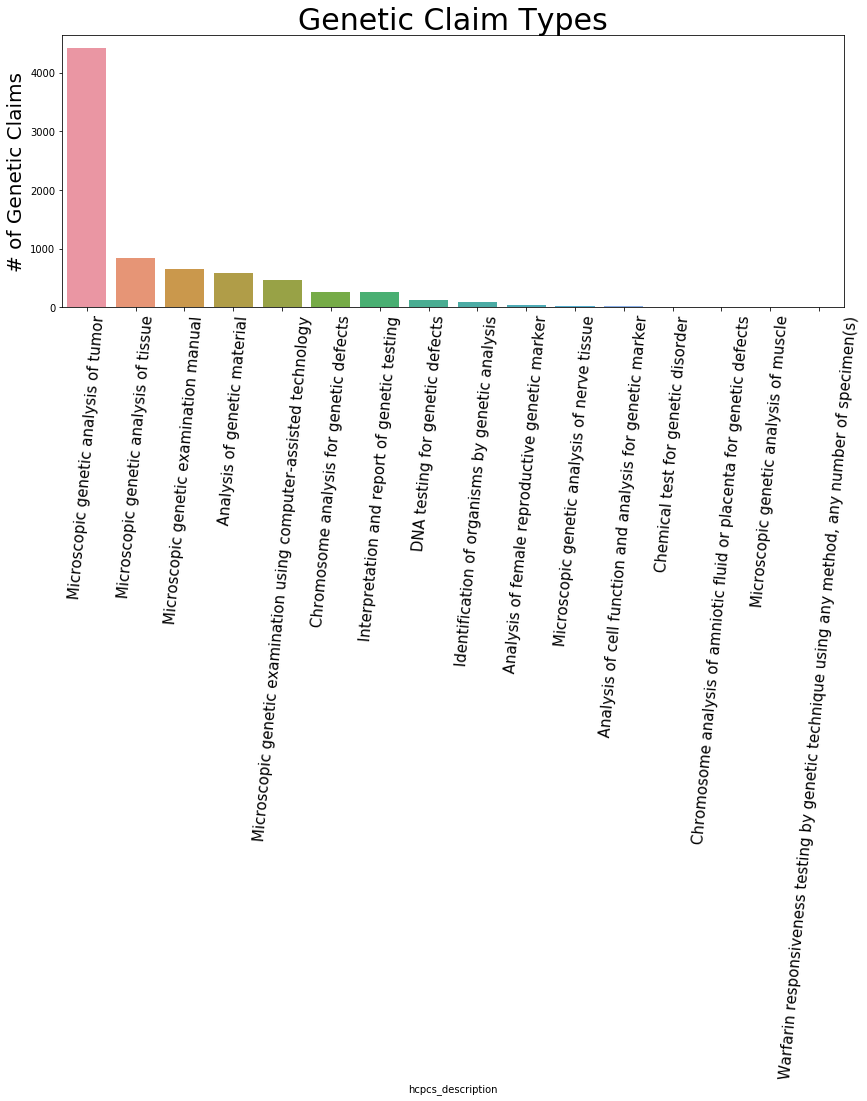

In [23]:
# Plot the Genetic Claim Types
width=14
height=5
figure(figsize=(width,height))

p = sns.barplot(x=genetic_tests15["hcpcs_description"], y  = genetic_tests15["count"])

plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=15)
plt.ylabel('# of Genetic Claims',fontsize=20)
plt.title('Genetic Claim Types',fontsize=30)
plt.xticks(rotation= 85,fontsize=15)

In [ ]:
df15.head(10)

In [ ]:
list(df15)

In [ ]:
genetic15 = df15[df15['hcpcs_description'].str.contains("genetic", na=False)]

In [ ]:
test_type15 = genetic15.groupby('hcpcs_description').size().reset_index(name='count')
test_type15.sort_values(by='count', ascending=False,inplace=True)
test_type15

In [ ]:
tumors15 = genetic15[genetic15['hcpcs_description'].str.contains("Microscopic genetic analysis of tumor", na=False)]
tumors15.groupby('provider_type').size()

In [ ]:
report15 = genetic15[genetic15['hcpcs_description'].str.contains("Interpretation and report of genetic testing", na=False)]
report15.groupby('provider_type').size()

In [ ]:
tumors15

In [ ]:
# List the addresses of tumor claims

tumors15.nppes_provider_street1

## LOAD THE 215 RESEARCH CLINICS, TO MATCH ADDRESSES



In [ ]:
research = pd.read_csv(datadir + '215_research_clinics.csv')
research.shape

In [ ]:
# convert two address columns to Series
research_mailing_address = pd.Series(research['Mailing Address'])
research_practice_address = pd.Series(research['Practice Address'])

In [ ]:
# perform matching
(
    tumors15.nppes_provider_street1.isin(research_mailing_address) |
    tumors15.nppes_provider_street1.isin(research_practice_address)
).value_counts()

So of the **4126** tumor tests, 12 came from research clinics

In [ ]:
(
    genetic15.nppes_provider_street1.isin(research_mailing_address) |
    genetic15.nppes_provider_street1.isin(research_practice_address)
).value_counts()

# LOAD THE 25,659 Oncology clinics, to match addresses

In [ ]:
onclinics = pd.read_csv(datadir + '25K-oncology-deduped.csv')
onclinics.shape

In [ ]:
list(onclinics)

In [ ]:
onclinic_address = pd.Series(onclinics.ADDRESS)

In [ ]:
onclinic_address

In [ ]:
genetic15.nppes_provider_street1.isin(onclinic_address).value_counts()

In [ ]:
3293+3236

In [ ]:
# convert two address columns to Series
onclinics_mailing_address = pd.Series(onclinics['Mailing Address'])
onclinics_practice_address = pd.Series(onclinics['Practice Address'])

In [ ]:
# perform matching
(
    tumors15.nppes_provider_street1.isin(onclinics_mailing_address) |
    tumors15.nppes_provider_street1.isin(onclinics_practice_address)
).value_counts()

In [ ]:
list(onclinics)

In [ ]:
1952+2174

In [ ]:
tumors15.nppes_provider_street1.isin(research_practice_address).value_counts()

In [ ]:
peachtree = tumors15.nppes_provider_street1.str.contains("1968 PEACHTREE RD NW")
tumors15[peachtree]

In [ ]:
tumors15.nppes_provider_street1.isin(["1968 PEACHTREE RD NW","1 MEDICAL CENTER DR"]).value_counts()

In [ ]:
entities = df15.groupby('nppes_entity_code').size().reset_index(name='count')
entities.sort_values(by='count', ascending=False,inplace=True)
entities

In [ ]:
providers = df15.groupby('provider_type').size().reset_index(name='count')
providers.sort_values(by='count', ascending=False,inplace=True)
providers